### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

We will start by installing and importing the required libraries.

In [1]:
# Import the required libraries.
import os
import cv2
#import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from keras.layers import *
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau

In [4]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [5]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

SEQUENCE_LENGTH = 20

'''
DATASET_DIR = "Video_Neveen_as_circles"

CLASSES_LIST = ["Starvation", "hypoxia_feeding" , "normal_feeding" , "thermal_shock"]
'''


DATASET_DIR = "Vids_Knowledge_Testing"

CLASSES_LIST = ["1", "2"]



In [6]:
def frames_extraction(video_path):


    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    print('frame count' , video_frames_count)
    target_frames = 59

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count / target_frames), 1)

    for frame_counter in range(target_frames):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list


In [7]:
def create_dataset(DATASET_DIR):
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos on disk.
    '''
    features = []
    labels = []
    video_files_paths = []

    max_sequence_length = 0  # Maximum sequence length in the dataset

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        print('Navoon' , DATASET_DIR)
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)
            print('length of frames ' , np.array(frames).shape , np.array(frames).shape[0])
            features.append(frames)
            labels.append(class_index)
            video_files_paths.append(video_file_path)
            
            # Update the maximum sequence length
            if len(frames) > max_sequence_length:
                max_sequence_length = len(frames)


    print(max_sequence_length)
    fcd = 0
    video_order = 0
    # Pad the frames to ensure equal length
    print(len(features))
    for i in range(len(features)):
            video_order += 1
            frames = features[i]
            num_frames = len(frames)
            gf = 0
            path_tkag = 'Testing_Trajectories'+ '/' + str(labels[i]) + '/' + str(video_order)
            os.makedirs(path_tkag , exist_ok=True)

            if num_frames <= max_sequence_length:
                padding_frames = max_sequence_length - num_frames
                padded_frames = np.pad(frames, ((0, padding_frames), (0, 0), (0, 0), (0, 0)), mode='constant')
                features[i] = padded_frames
                ctr = 0
                for c in padded_frames:
                    cv2.imwrite(path_tkag + '/' + str(ctr) + '.png'  , c)
                    ctr += 1
            



    # Convert the lists to numpy arrays
    features = np.array(features)
    labels = np.array(labels)
    return features, labels, video_files_paths

Now we will utilize the function **`create_dataset()`** created above to extract the data of the selected classes and create the required dataset.

In [8]:
# Create the dataset.
#features_train_rgb, labels, video_files_paths = create_dataset('Neveen_Divided_vids_2')
#features_train_trajectory, labels, video_files_paths = create_dataset('Full_Time_Trajectory_for_Final_Videos_Copy')
features_train_trajectory, labels, video_files_paths = create_dataset('Vids_Knowledge_Testing')

#bb, ll, vf = create_dataset('Neveen_vids_traj_testing_2')

Extracting Data of Class: 1
Navoon Vids_Knowledge_Testing
frame count 10
length of frames  (10, 64, 64, 3) 10
frame count 10
length of frames  (10, 64, 64, 3) 10
frame count 10
length of frames  (10, 64, 64, 3) 10
frame count 7
length of frames  (7, 64, 64, 3) 7
frame count 17
length of frames  (17, 64, 64, 3) 17
frame count 17
length of frames  (17, 64, 64, 3) 17
frame count 17
length of frames  (17, 64, 64, 3) 17
frame count 6
length of frames  (6, 64, 64, 3) 6
frame count 6
length of frames  (6, 64, 64, 3) 6
frame count 6
length of frames  (6, 64, 64, 3) 6
frame count 6
length of frames  (6, 64, 64, 3) 6
frame count 6
length of frames  (6, 64, 64, 3) 6
frame count 6
length of frames  (6, 64, 64, 3) 6
frame count 4
length of frames  (4, 64, 64, 3) 4
frame count 4
length of frames  (4, 64, 64, 3) 4
frame count 4
length of frames  (4, 64, 64, 3) 4
frame count 12
length of frames  (12, 64, 64, 3) 12
frame count 12
length of frames  (12, 64, 64, 3) 12
frame count 12
length of frames  (12

Now we will convert `labels` (class indexes) into one-hot encoded vectors.

In [9]:
print(labels)
one_hot_encoded_labels = to_categorical(labels)
print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [10]:
print(len(labels))

354


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
features_train, features_test, labels_train, labels_test = train_test_split(features_train_trajectory, one_hot_encoded_labels,
                                                                            test_size = 0.2, shuffle = True,
                                                                            random_state = seed_constant)

In [ ]:
features_train_temp, features_test, labels_train_temp, labels_test = train_test_split(features_train_trajectory, one_hot_encoded_labels,
                                                                            test_size = 0.1, shuffle = True,
                                                                            random_state = seed_constant, stratify = one_hot_encoded_labels)

# Second, split the remaining data into a training set and a validation set
features_train, features_val, labels_train, labels_val = train_test_split(features_train_temp, labels_train_temp,
                                                                          test_size=0.1, shuffle=True,
                                                                          random_state=seed_constant, stratify=labels_train_temp)

In [13]:
print(len(features_train))

283


In [ ]:
def L1():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (None, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (None, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [ ]:
def create_advanced_LRCN_model():
    '''
    This function will construct a more advanced LRCN model.
    Returns:
        model: It is the required constructed advanced LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu'),
                              input_shape=(None, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.3)))

    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((3, 3))))
    model.add(TimeDistributed(Dropout(0.3)))
    model.add(TimeDistributed(Flatten()))
    #model.add(LSTM(64, return_sequences=True))  # LSTM layer with more units and it returns sequences
    #model.add(LSTM(32))  # Additional LSTM layer for better temporal dependency learning
    model.add(LSTM(64))
    model.add(Dropout(0.3))  # Added another Dropout layer for regularization after LSTM layers

    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    ########################################################################################################################

    # Display the model's summary.
    model.summary()

    # Return the constructed advanced LRCN model.
    return model


In [37]:
def create_LRCN_model():
    model = Sequential()

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'),
                            input_shape=(None, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(64, return_sequences=True, dropout=0.2))
    model.add(LSTM(64, dropout=0.2))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.summary()

    return model


In [ ]:
#mer
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''
 
    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((3, 3))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((3, 3))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((3, 3))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))
 
    ########################################################################################################################
 
    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [79]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization

def create_Conv3D_model():
    '''
    This function will construct the required Conv3D model.
    Returns:
        model: It is the required constructed Conv3D model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    
    # 3D Convolutional Layer
    model.add(Conv3D(8, kernel_size=(3, 3, 3), activation='relu', 
                     input_shape=(59, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(3, 3, 3)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed Conv3D model.
    return model


In [ ]:
from keras.regularizers import l2

def L_best_one():
    model = Sequential()

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu'),
                              input_shape=(None, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.35)))  # Lower dropout rate in the convolutional layers
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(64))  # Introduce dropout in the LSTM layer
    model.add(Dropout(0.35))  # Keep dropout in the fully connected layer
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))  # Regularization in the output layer

    model.summary()

    return model


In [139]:
#YEEEEESSSTHEBESTONE
def create_LRCN_model():
    model = Sequential()

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'),
                              input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((3, 3))))
    model.add(TimeDistributed(Dropout(0.3)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))

    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(32))
    model.add(Dropout(0.3))

    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.summary()

    return model


In [15]:

def be_a_man():
    model = Sequential()

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'),
                              input_shape=(59, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))

    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(64))
    model.add(Dropout(0.2))
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.summary()

    return model


In [ ]:

def sample():
    model = Sequential()

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'),
                              input_shape=(59, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))

    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(64))
    model.add(Dropout(0.2))
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.summary()

    return model

In [42]:

def testing():
    model = Sequential()

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'),
                              input_shape=(59, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((3, 3))))
    model.add(TimeDistributed(Dropout(0.3)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(64))
    model.add(Dropout(0.2))
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.summary()

    return model


Now we will utilize the function **`create_LRCN_model()`** created above to construct the required `LRCN` model.

In [85]:
# Construct the required LRCN model.
LRCN_model_2 = sample()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_5"
_________________________________________________________________


 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 57, 62, 62, 8)     656       
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 19, 20, 20, 8)    0         
 3D)                                                             
                                                                 
 dropout_23 (Dropout)        (None, 19, 20, 20, 8)     0         
                                                                 
 flatten_5 (Flatten)         (None, 60800)             0         
                                                                 
 dense_11 (Dense)            (None, 2)                 121602    
                                                                 
Total params: 122,258
Trainable params: 122,258
Non-trainable params: 0
_________________________________________________________________
Model Created Successfully!


In [84]:
del LRCN_model_2

#### **<font style="color:rgb(134,19,348)">Check Model’s Structure:</font>**

Now we will use the **`plot_model()`** function to check the structure of the constructed `LRCN` model. As we had checked for the previous model.

In [ ]:
plot_model(LRCN_model_2, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
for f in features_train:
  for p in f:
    for q in p:
      for c in q:
       for h in c:
        if(h != 0.0):
          print(h)
          print('hello')

0.01568627450980392
hello
0.011764705882352941
hello
0.00392156862745098
hello
0.00392156862745098
hello
0.00392156862745098
hello
0.00392156862745098
hello
0.00784313725490196
hello
0.01568627450980392
hello
0.00392156862745098
hello
0.0196078431372549
hello
0.011764705882352941
hello
0.011764705882352941
hello
0.00392156862745098
hello
0.00784313725490196
hello
0.00784313725490196
hello
0.00392156862745098
hello
0.00784313725490196
hello
0.011764705882352941
hello
0.00392156862745098
hello
0.00392156862745098
hello
0.011764705882352941
hello
0.011764705882352941
hello
0.00392156862745098
hello
0.00392156862745098
hello
0.00392156862745098
hello
0.00392156862745098
hello
0.00392156862745098
hello
0.00392156862745098
hello
0.00392156862745098
hello
0.00392156862745098
hello
0.00784313725490196
hello
0.00392156862745098
hello
0.00392156862745098
hello
0.00392156862745098
hello
0.00392156862745098
hello
0.00784313725490196
hello
0.00392156862745098
hello
0.011764705882352941
hello
0.0117

KeyboardInterrupt: 

In [83]:
print(len(features_train))
print(len(features_train) * 0.2)

283
56.6


In [60]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


### **<font style="color:rgb(134,19,348)">Step 5.2: Compile & Train the Model</font>**


After checking the structure, we will compile and start training the model.

In [61]:
import tensorflow as tf
from keras.callbacks import TensorBoard
import datetime

In [86]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 20, verbose= 1, restore_best_weights = True)
model_checkpoint = ModelCheckpoint('test.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose = 1 , patience=3, min_lr=0.000001)
log_dir = "logs/fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
LRCN_model_2.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["categorical_accuracy"])

LRCN_model_training_history = LRCN_model_2.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 8 , validation_split = 0.2, callbacks = [early_stopping_callback , model_checkpoint , tensorboard_callback , reduce_lr])

Epoch 1/50
29/29 [==============================] - ETA: 0s - loss: 0.5149 - categorical_accuracy: 0.7212
Epoch 1: val_loss improved from inf to 0.39494, saving model to 3DCNN_Jury_Knowledge.h5
29/29 [==============================] - 4s 104ms/step - loss: 0.5149 - categorical_accuracy: 0.7212 - val_loss: 0.3949 - val_categorical_accuracy: 0.7895 - lr: 0.0010
Epoch 2/50
28/29 [===========================>..] - ETA: 0s - loss: 0.3275 - categorical_accuracy: 0.8527
Epoch 2: val_loss improved from 0.39494 to 0.31096, saving model to 3DCNN_Jury_Knowledge.h5
29/29 [==============================] - 2s 78ms/step - loss: 0.3261 - categorical_accuracy: 0.8540 - val_loss: 0.3110 - val_categorical_accuracy: 0.8947 - lr: 0.0010
Epoch 3/50
28/29 [===========================>..] - ETA: 0s - loss: 0.2194 - categorical_accuracy: 0.9062
Epoch 3: val_loss improved from 0.31096 to 0.30565, saving model to 3DCNN_Jury_Knowledge.h5
29/29 [==============================] - 2s 82ms/step - loss: 0.2179 - cate

#### **<font style="color:rgb(134,19,348)">Evaluating the trained Model</font>**

As done for the previous one, we will evaluate the `LRCN` model on the test set.

In [93]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model_2.evaluate(features_test, labels_test)

3/3 [==============================] - 0s 68ms/step - loss: 0.1940 - categorical_accuracy: 0.9296


In [91]:
best_val_loss_epoch = LRCN_model_training_history.history['val_loss'].index(min(LRCN_model_training_history.history['val_loss']))

# Print the best loss and validation loss
print('Best loss: {:.4f}'.format(LRCN_model_training_history.history['loss'][best_val_loss_epoch]))
print('Best accuracy: {:.4f}'.format(LRCN_model_training_history.history['categorical_accuracy'][best_val_loss_epoch]))
print('Best validation loss: {:.4f}'.format(LRCN_model_training_history.history['val_loss'][best_val_loss_epoch]))
print('Best validation accuracy: {:.4f}'.format(LRCN_model_training_history.history['val_categorical_accuracy'][best_val_loss_epoch]))

Best loss: 0.0254
Best accuracy: 0.9912
Best validation loss: 0.1575
Best validation accuracy: 0.9123


In [94]:
print(best_val_loss_epoch)

16


In [ ]:
#best epoch best_val_loss_epoch + 1

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])
cat 1.0
val_cat 0.9298245906829834
loss 0.01012069545686245
val_loss 0.20609025657176971


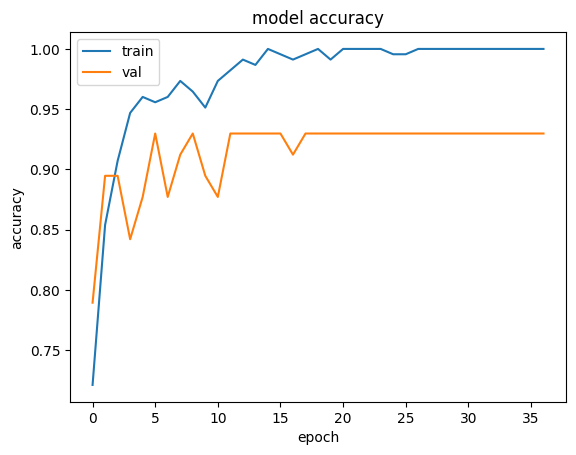

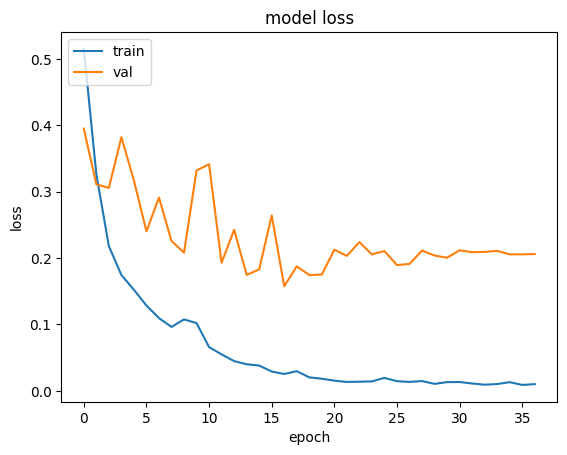

In [90]:
import matplotlib.pyplot as plt
import numpy as np

print(LRCN_model_training_history.history.keys())
print('cat',LRCN_model_training_history.history['categorical_accuracy'][-1])
print('val_cat',LRCN_model_training_history.history['val_categorical_accuracy'][-1])
print('loss',LRCN_model_training_history.history['loss'][-1])
print('val_loss',LRCN_model_training_history.history['val_loss'][-1])
# summarize history for accuracy
plt.plot(LRCN_model_training_history.history['categorical_accuracy'])
plt.plot(LRCN_model_training_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(LRCN_model_training_history.history['loss'])
plt.plot(LRCN_model_training_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [33]:
from keras.models import Model

In [45]:
LRCN_model_2.save('poster_last_LRCNN.h5')

In [ ]:
one_hot_encoded_labels = to_categorical(labels)
rgb_features_train, rgb_features_test, labels_train, labels_test = train_test_split(features_train_rgb, one_hot_encoded_labels, test_size=0.2, random_state=42)
trajectory_features_train, trajectory_features_test, _, _ = train_test_split(features_train_trajectory, one_hot_encoded_labels, test_size=0.2, random_state=42)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Flatten, LSTM, Dense, TimeDistributed

# Define the image dimensions
height, width, channels = 64, 64, 3  # For RGB
height_traj, width_traj, channels_traj = 64, 64, 3  # For trajectory


rgb_model = Sequential()
rgb_model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (None, height, width, 3))) 
rgb_model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
rgb_model.add(TimeDistributed(Dropout(0.25)))
rgb_model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
rgb_model.add(TimeDistributed(MaxPooling2D((4, 4))))
rgb_model.add(TimeDistributed(Dropout(0.25)))
rgb_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
rgb_model.add(TimeDistributed(MaxPooling2D((2, 2))))
rgb_model.add(TimeDistributed(Dropout(0.25)))
rgb_model.add(TimeDistributed(Flatten()))                                      
rgb_model.add(LSTM(50, return_sequences=False, name='last_layer_rgb'))  

traj_model = Sequential()
traj_model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (None, height, width, 3))) 
traj_model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
traj_model.add(TimeDistributed(Dropout(0.25)))
traj_model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
traj_model.add(TimeDistributed(MaxPooling2D((4, 4))))
traj_model.add(TimeDistributed(Dropout(0.25)))
traj_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
traj_model.add(TimeDistributed(MaxPooling2D((2, 2))))
traj_model.add(TimeDistributed(Dropout(0.25)))
traj_model.add(TimeDistributed(Flatten()))          
traj_model.add(LSTM(50, return_sequences=False, name='last_layer_traj')) 

combined = Concatenate()([rgb_model.output, traj_model.output])
out = Dense(4, activation='softmax')(combined)
model = Model(inputs=[rgb_model.input, traj_model.input], outputs=out)


In [ ]:
del rgb_model , traj_model , model

In [ ]:
print(labels_train)

[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 30, mode = 'min', restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["categorical_accuracy"])

Combined_Traj_RGB = model.fit(x = [rgb_features_train,trajectory_features_train], y = labels_train, epochs = 70, batch_size = 3 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
9/9 [==============================] - 7s 236ms/step - loss: 1.4284 - categorical_accuracy: 0.1600 - val_loss: 1.4391 - val_categorical_accuracy: 0.2857
Epoch 2/70
9/9 [==============================] - 0s 43ms/step - loss: 1.1773 - categorical_accuracy: 0.6400 - val_loss: 1.3719 - val_categorical_accuracy: 0.2857
Epoch 3/70
9/9 [==============================] - 0s 41ms/step - loss: 0.9283 - categorical_accuracy: 0.6800 - val_loss: 0.9371 - val_categorical_accuracy: 0.5714
Epoch 4/70
9/9 [==============================] - 0s 45ms/step - loss: 0.6581 - categorical_accuracy: 0.8000 - val_loss: 0.9568 - val_categorical_accuracy: 0.4286
Epoch 5/70
9/9 [==============================] - 0s 41ms/step - loss: 0.5468 - categorical_accuracy: 0.7600 - val_loss: 0.5938 - val_categorical_accuracy: 1.0000
Epoch 6/70
9/9 [==============================] - 0s 42ms/step - loss: 0.5147 - categorical_accuracy: 0.8800 - val_loss: 0.5557 - val_categorical_accuracy: 0.8571
Epoch 7/70
9/9 [=====

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])
cat 1.0
val_cat 1.0
loss 0.00038451424916274846
val_loss 0.0011827131966128945


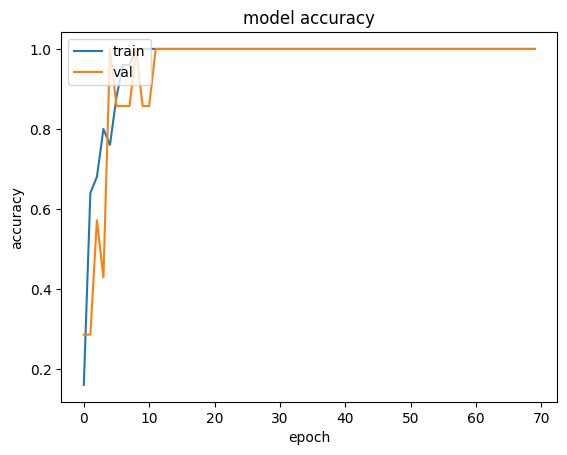

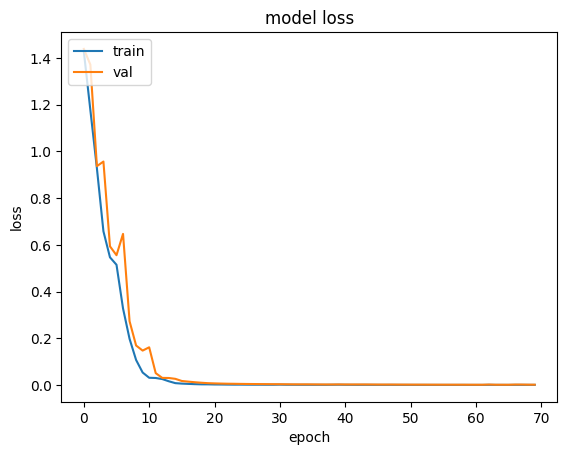

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

print(Combined_Traj_RGB.history.keys())
print('cat',Combined_Traj_RGB.history['categorical_accuracy'][-1])
print('val_cat',Combined_Traj_RGB.history['val_categorical_accuracy'][-1])
print('loss',Combined_Traj_RGB.history['loss'][-1])
print('val_loss',Combined_Traj_RGB.history['val_loss'][-1])
# summarize history for accuracy
plt.plot(Combined_Traj_RGB.history['categorical_accuracy'])
plt.plot(Combined_Traj_RGB.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(Combined_Traj_RGB.history['loss'])
plt.plot(Combined_Traj_RGB.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
